## Topic Modeling with Latent Dirichlet Allocation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from pathlib import Path
import os
import glob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.io.json import json_normalize
import json

import pprint
import string

import matplotlib.pyplot as plt
import seaborn as sns

import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# for filename in fnmatch.filter(filenames, '*.txt'):
# Any results you write to the current directory are saved as output.

In [2]:
input = Path('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge')
output = Path('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge/output')

biorxiv_medrxiv = Path('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv')


## Load the meta data file

In [3]:
df_all_sources_metadata = pd.read_csv(input / 'metadata.csv')

In [4]:
print(df_all_sources_metadata.shape)
df_all_sources_metadata.info()

(45774, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45774 entries, 0 to 45773
Data columns (total 17 columns):
cord_uid                       45774 non-null object
sha                            31753 non-null object
source_x                       45774 non-null object
title                          45617 non-null object
doi                            42440 non-null object
pmcid                          26243 non-null object
pubmed_id                      34641 non-null float64
license                        45774 non-null object
abstract                       37913 non-null object
publish_time                   45765 non-null object
authors                        43774 non-null object
journal                        41707 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1768 non-null object
has_full_text                  45774 non-null bool
full_text_file                 35558 non-null object
url                            454

In [5]:
df_all_sources_metadata.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866


In [6]:
pd.pivot_table(df_all_sources_metadata, index='full_text_file', values=['sha', 'source_x', 'has_full_text'], aggfunc={'sha': 'count', 'source_x': 'count', 'has_full_text': np.sum}, margins=True)

,has_full_text,sha,source_x
full_text_file,,,
biorxiv_medrxiv,1053.0,1053,1218
comm_use_subset,8864.0,8864,8982
custom_license,19816.0,19816,23227
noncomm_use_subset,2020.0,2020,2131
All,31753.0,31753,31753


## ReadIn the JSON Files

The following code for reading in the JSON file is taken from the notebook <b>COVID EDA: Initial Exploration Tool</b> by <i><b>Ivan Ega Pratama</b></i>

https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool

In [7]:
%%time
all_json = glob.glob(f'{biorxiv_medrxiv}/**/*.json', recursive=True)
len(all_json)

Wall time: 25.9 ms


1053

In [8]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            # Extend Here
            #
            #
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0015023cc06b5362d332b3baf348d11567ca2fbb: word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a si... VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structura...


In [9]:
%%time
dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
df_covid.head()

Processing index: 0 of 1053
Processing index: 105 of 1053
Processing index: 210 of 1053
Processing index: 315 of 1053
Processing index: 420 of 1053
Processing index: 525 of 1053
Processing index: 630 of 1053
Processing index: 735 of 1053
Processing index: 840 of 1053
Processing index: 945 of 1053
Processing index: 1050 of 1053
Wall time: 3.46 s


,paper_id,abstract,body_text
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP..."
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co..."
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...
3,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by..."
4,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...


In [10]:
dict_ = None

In [11]:
%%time
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

Wall time: 618 ms


,paper_id,abstract,body_text,abstract_word_count,body_word_count
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",241,1728
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",175,2549
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,0,755
3,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",1647,4003
4,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,326,2399


In [12]:
df_covid.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
paper_id,1053,1053,9444dbf96374f2efc528fb4ede46ecf41a2b69be,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract,1053,917,,136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_text,1053,1053,exponential before the time and softened after...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract_word_count,1053,NaN,NaN,NaN,252.814,353.19,0,93,185,276,4170
body_word_count,1053,NaN,NaN,NaN,3047.11,2441.36,206,1613,2494,3790,44741


In [13]:
df_covid.drop_duplicates(['body_text'], inplace=True)
df_covid.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
paper_id,1053,1053,9444dbf96374f2efc528fb4ede46ecf41a2b69be,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract,1053,917,,136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_text,1053,1053,exponential before the time and softened after...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract_word_count,1053,NaN,NaN,NaN,252.814,353.19,0,93,185,276,4170
body_word_count,1053,NaN,NaN,NaN,3047.11,2441.36,206,1613,2494,3790,44741


## Clean up the text

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS

In [15]:
lemmatizer = WordNetLemmatizer()

print("Number of stopwrods from STOPWORDS: ", len(STOPWORDS))
print("Number of stopwrods from stopwords.words('english'): ", len(stopwords.words('english')))
other_stopwords = ['q', 'license', 'preprint', 'copyright', 'http', 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si', 'cc']
custom_stopwords = []
custom_stopwords = list(set(stopwords.words('english') + list(STOPWORDS))) + other_stopwords

print("Number of stopwrods from custom_stopwords: ", len(custom_stopwords))
print(custom_stopwords[-25:])

Number of stopwrods from STOPWORDS:  190
Number of stopwrods from stopwords.words('english'):  179
Number of stopwrods from custom_stopwords:  264
['author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da', 'dell', 'non', 'si', 'cc']


In [16]:
def clean_the_text(text):
        text = re.sub('[^a-zA-Z0-9-]', ' ', text)
        tokens = word_tokenize(text)
        # remove_punc = [word for word in tokens if word not in string.punctuation]
        remove_stopwords = [word.lower() for word in tokens if word.lower() not in custom_stopwords]
        more_than_three = [w for w in remove_stopwords if len(w)>3]
        lem = [lemmatizer.lemmatize(w) for w in more_than_three]
        return ' '.join(lem)

# cleaned_text = clean_the_text("my name is TRIVIKRAM, and I am first born in my fam don't process processing patients")
# print(cleaned_text)

In [17]:
df_covid_for_nlp = df_covid.copy()
df_covid = None

In [18]:
%%time
df_covid_for_nlp['cleaned_text'] = df_covid_for_nlp['body_text'].apply(lambda x: clean_the_text(x))

Wall time: 1min 13s


In [19]:
df_covid_for_nlp['cleaned_text'].head()

0    processed virus assembly region encode non-str...
1    december 2019 novel coronavirus sars-cov-2 ide...
2    2019-ncov epidemic spread across china country...
3    infectious bronchitis caused infectious bronch...
4    nipah infectious negative-sense single-strande...
Name: cleaned_text, dtype: object

In [20]:
# placeholder cell to sub-set data
# df_covid_for_nlp_10K = df_covid_for_nlp.head(10000).copy()
# df_covid_for_nlp_10K.shape

# Topic Modeling using Latent Dirichlet Allocation (LDA)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

### Convert the text data to Term frequency - Inverse Document frequency

In [22]:
%%time 

tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix_Tfidf = tfidf_vect.fit_transform(df_covid_for_nlp['cleaned_text'].values.astype('U'))

Wall time: 3.43 s


In [23]:
doc_term_matrix_Tfidf

<1053x19444 sparse matrix of type '<class 'numpy.float64'>'
	with 509750 stored elements in Compressed Sparse Row format>

### Use GridSearchCV to find the best parameters for LDA

In [24]:
%%time
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30, 50], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
grid_search_model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1)

# Do the Grid Search
grid_search_model.fit(doc_term_matrix_Tfidf)

Wall time: 7min 40s


GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [25]:
# Best Model
best_lda_model = grid_search_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid_search_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid_search_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_term_matrix_Tfidf))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -35031.331585753236
Model Perplexity:  42256.93772531144


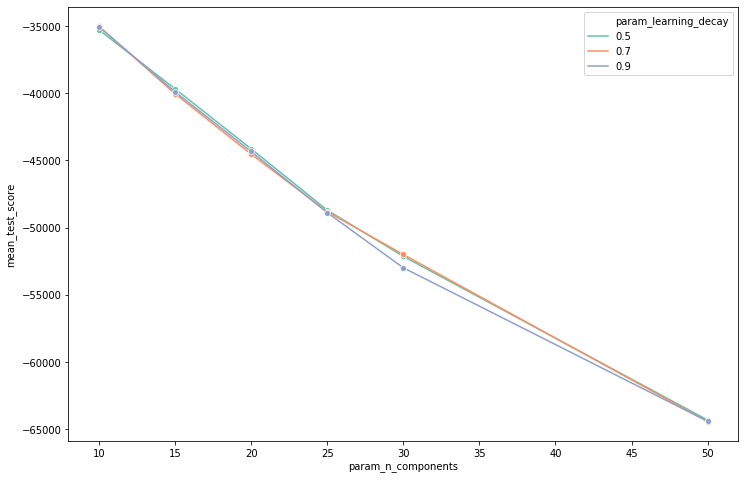

In [26]:
df_results = pd.DataFrame(grid_search_model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=df_results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             palette=current_palette,
             marker='o')

plt.show()

### Getting 10 random features

In [27]:
import random

for i in range(10):
    random_id = random.randint(0,len(tfidf_vect.get_feature_names()))
    print(tfidf_vect.get_feature_names()[random_id])

monotone
87
relay
lucy
ramos
psychology
swedish
fuel
treg
nuclear


### Print the top 10 words from the first topic

In [28]:
first_topic = best_lda_model.components_[0]

In [29]:
top_topic_words = first_topic.argsort()[-10:]
top_topic_words

array([ 1296,  6629, 15180, 16349,  6999,  7792,  2732, 11639, 14209,
        3520], dtype=int64)

In [30]:
for i in top_topic_words:
    print(tfidf_vect.get_feature_names()[i])

ace2
epitope
residue
site
expression
gene
binding
mouse
protein
cell


### Print the top 10 words topic wise

In [31]:
for i,topic in enumerate(best_lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['ace2', 'epitope', 'residue', 'site', 'expression', 'gene', 'binding', 'mouse', 'protein', 'cell']


Top 10 words for topic #1:
['ifit3', 'odor', 'haloperidol', 'vaginal', 'ifit1', 'meplazumab', 'facemask', 'transferrin', 'betacov', 'bladder']


Top 10 words for topic #2:
['ighv', 'narnaviruses', 'efflux', 'p10', 'detections', 'rv', 'fcov', 'chop', 'esir', 'g3bp1']


Top 10 words for topic #3:
['bcl', 'mir', 'devil', 'niid', 'ompa', 'klk13', 'cd63', 'hsa', 'seattle', 'tlr4']


Top 10 words for topic #4:
['rnaaemia', 'placental', 'californica', 'sporulation', 'rosette', 'hm3dq', 'gbf1', 'denv4', 'cd147', 'vp35']


Top 10 words for topic #5:
['myocardial', 'procalcitonin', 'nt', 'trim25', 'ritonavir', 'corticosteroid', 'aminotransferase', 'cardiac', 'neutrophil', 'il']


Top 10 words for topic #6:
['granted', 'perpetuity', 'sars', 'cov', '19', 'covid', '2020', 'case', 'patient', 'medrxiv']


Top 10 words for topic #7:
['swnt', 'diff', 'seizure', 'swine', 'litt

### Find the most dominant topic in each document

In [32]:
topic_values_tfidf = best_lda_model.transform(doc_term_matrix_Tfidf)
topic_values_tfidf.shape

(1053, 10)

In [33]:
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

rows = df_covid_for_nlp['paper_id']

In [34]:
df_topic_values_tfidf = pd.DataFrame(topic_values_tfidf, columns=topicnames, index=rows)

In [35]:
df_topic_values_tfidf['topic_number_tfidf'] = topic_values_tfidf.argmax(axis=1)

In [36]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [37]:
df_topic_values_tfidf.head(10).style.applymap(color_green).applymap(make_bold)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,topic_number_tfidf
paper_id,,,,,,,,,,,
0015023cc06b5362d332b3baf348d11567ca2fbb,0.415062,0.00717048,0.00717049,0.00717048,0.00717048,0.00717048,0.527574,0.00717048,0.00717048,0.00717048,6
00340eea543336d54adda18236424de6a5e91c9d,0.0146942,0.181488,0.0146735,0.0146736,0.0146735,0.0146737,0.70109,0.0146859,0.0146735,0.0146735,6
004f0f8bb66cf446678dc13cf2701feec4f36d76,0.00902802,0.00902682,0.00902682,0.00902682,0.00902682,0.00902682,0.918757,0.00902682,0.00902682,0.00902682,6
00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,0.030744,0.00787297,0.00787297,0.00787297,0.00787297,0.00787297,0.906272,0.00787314,0.00787297,0.00787297,6
0139ea4ca580af99b602c6435368e7fdbefacb03,0.198243,0.00717419,0.00717419,0.00717419,0.00717419,0.00717621,0.744362,0.00717419,0.00717419,0.00717419,6
013d9d1cba8a54d5d3718c229b812d7cf91b6c89,0.00711274,0.00709377,0.00709377,0.00709377,0.00709377,0.00709377,0.936137,0.00709377,0.00709377,0.00709377,6
01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,0.308948,0.00744842,0.00744842,0.00744842,0.00744842,0.00745658,0.631457,0.00744842,0.00744842,0.00744842,6
01e3b313e78a352593be2ff64927192af66619b5,0.335167,0.0150735,0.0150759,0.0150735,0.0150735,0.0150735,0.544224,0.0150925,0.0150735,0.0150735,6
02201e4601ab0eb70b6c26480cf2bfeae2625193,0.00794526,0.00794216,0.00794216,0.00794216,0.00794216,0.00794215,0.928517,0.00794216,0.00794216,0.00794216,6


### Create a dataframe for the 10 topics

In [38]:
dict_topic = {'topic_number_tfidf': [], 'topic_words_tfidf': []}

for i,topic in enumerate(best_lda_model.components_):
    dict_topic['topic_number_tfidf'].append(i)
    dict_topic['topic_words_tfidf'].append([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])

df_covid_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number_tfidf', 'topic_words_tfidf'])
df_covid_topics_tfidf.head(10)

,topic_number_tfidf,topic_words_tfidf
0,0,"[ace2, epitope, residue, site, expression, gen..."
1,1,"[ifit3, odor, haloperidol, vaginal, ifit1, mep..."
2,2,"[ighv, narnaviruses, efflux, p10, detections, ..."
3,3,"[bcl, mir, devil, niid, ompa, klk13, cd63, hsa..."
4,4,"[rnaaemia, placental, californica, sporulation..."
5,5,"[myocardial, procalcitonin, nt, trim25, ritona..."
6,6,"[granted, perpetuity, sars, cov, 19, covid, 20..."
7,7,"[swnt, diff, seizure, swine, litter, worm, ied..."
8,8,"[asfv, sre, secy, ctds, speech, curvature, sle..."
9,9,"[par, jelly, dftd, ccl2, foxp3, muc5ac, sleep,..."


## Visualization using pyLDAvis

The visualization is a learning from the following source

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [39]:
import pyLDAvis
import pyLDAvis.sklearn

In [40]:
%%time

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, doc_term_matrix_Tfidf, tfidf_vect, mds='tsne', sort_topics=False)
panel

C:\Users\trivikram.cheedella\MyInstalledSoftware\Continuum\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Wall time: 16min 13s


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  13.778496
1       0.648955  71.707100       2        1   0.942685
2      71.019684   9.971006       3        1   0.857292
3       3.785981  33.185135       4        1   0.981717
4     -42.666500  -9.222070       5        1   0.885103
5      -3.621689 -43.526516       6        1   1.530673
6      -3.632402  -4.171708       7        1  78.140634
7     -36.584400  35.804413       8        1   1.058059
8      44.391380  50.615383       9        1   0.900235
9      40.235809 -31.591665      10        1   0.925105, topic_info=      Category       Freq          Term      Total  loglift  logprob
3520   Default  24.000000          cell  24.000000  30.0000  30.0000
14209  Default  17.000000       protein  17.000000  29.0000  29.0000
7792   Default  14.000000          gene  14.000000  28.0000  28.0000
2732   Default   6.000000       binding   6.000000  27.0000  27.0000
11639  Default   6.000000         mouse   6.000000  26.0000  26.0000
...        ...        ...           ...        ...      ...      ...
3488   Topic10   0.015258           cd4   0.187494   2.1744  -8.9159
4929   Topic10   0.019075        curtis   0.235284   2.1706  -8.6926
15544  Topic10   0.018138         royal   0.229813   2.1437  -8.7430
8730   Topic10   0.027383           hrv   0.445186   1.8944  -8.3311
17619  Topic10   0.018377  tetracycline   0.239725   2.1146  -8.7299

[387 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
367        7  0.988160            19
499        7  0.996194          2019
505        7  0.992833          2020
1296       1  0.428974          ace2
1296       7  0.643461          ace2
...      ...       ...           ...
18048      7  0.975133  transmission
18166      1  0.775906          trna
18934      1  0.040348         virus
18934      7  0.968346         virus
19302      7  1.005782         wuhan

[112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### Merge the Topic numbers and top 10 words of each topic to the Meta Data for further analysis

In [41]:
df_covid_for_nlp['topic_number_tfidf'] = topic_values_tfidf.argmax(axis=1)

In [42]:
df_covid_for_nlp.head(3)

,paper_id,abstract,body_text,abstract_word_count,body_word_count,cleaned_text,topic_number_tfidf
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",241,1728,processed virus assembly region encode non-str...,6
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",175,2549,december 2019 novel coronavirus sars-cov-2 ide...,6
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,0,755,2019-ncov epidemic spread across china country...,6


In [43]:
df_covid_for_nlp['topic_number_tfidf'].value_counts()

6    967
0     85
7      1
Name: topic_number_tfidf, dtype: int64

In [44]:
df_covid_for_nlp = df_covid_for_nlp.merge(df_covid_topics_tfidf, how='left', left_on='topic_number_tfidf', right_on='topic_number_tfidf')

In [45]:
df_covid_for_nlp.head(3)

,paper_id,abstract,body_text,abstract_word_count,body_word_count,cleaned_text,topic_number_tfidf,topic_words_tfidf
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",241,1728,processed virus assembly region encode non-str...,6,"[granted, perpetuity, sars, cov, 19, covid, 20..."
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",175,2549,december 2019 novel coronavirus sars-cov-2 ide...,6,"[granted, perpetuity, sars, cov, 19, covid, 20..."
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,0,755,2019-ncov epidemic spread across china country...,6,"[granted, perpetuity, sars, cov, 19, covid, 20..."


In [46]:
df_covid_for_nlp.columns

Index(['paper_id', 'abstract', 'body_text', 'abstract_word_count',
       'body_word_count', 'cleaned_text', 'topic_number_tfidf',
       'topic_words_tfidf'],
      dtype='object')

In [47]:
df_all_sources_metadata_with_topics = df_all_sources_metadata.copy()
df_all_sources_metadata_with_topics.shape

(45774, 17)

In [48]:
# df_all_sources_metadata_with_topics = df_all_sources_metadata_with_topics.merge(df_covid_for_nlp_10K[['paper_id', 'topic_count_vector', 'topic_words_count_vector', 'topic_tfidf', 'topic_words_tfidf', 'body_word_count']], how='left', left_on='sha', right_on='paper_id')

df_all_sources_metadata_with_topics = df_all_sources_metadata.merge(
    df_covid_for_nlp[['paper_id', 'abstract_word_count', 'body_word_count', 'cleaned_text', 'topic_number_tfidf', 'topic_words_tfidf']], 
    how='left', 
    left_on='sha', 
    right_on='paper_id')

In [49]:
print(df_all_sources_metadata_with_topics.columns)
print(df_all_sources_metadata_with_topics.shape)
df_all_sources_metadata_with_topics.head()

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text',
       'full_text_file', 'url', 'paper_id', 'abstract_word_count',
       'body_word_count', 'cleaned_text', 'topic_number_tfidf',
       'topic_words_tfidf'],
      dtype='object')
(45774, 23)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,WHO #Covidence,has_full_text,full_text_file,url,paper_id,abstract_word_count,body_word_count,cleaned_text,topic_number_tfidf,topic_words_tfidf
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727,f056da9c64fbf00a4645ae326e8a4339d015d155,183.0,3692.0,many different method characterize mixture org...,6.0,"[granted, perpetuity, sars, cov, 19, covid, 20..."
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889,daf32e013d325a6feb80e83d15aabc64a48fae33,136.0,5000.0,term metapopulation coined levins 1969 describ...,6.0,"[granted, perpetuity, sars, cov, 19, covid, 20..."
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,200.0,5478.0,antibody essential component immune system pla...,6.0,"[granted, perpetuity, sars, cov, 19, covid, 20..."
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476,4da8a87e614373d56070ed272487451266dce919,298.0,6486.0,metagenomics defined analysis collection seque...,6.0,"[granted, perpetuity, sars, cov, 19, covid, 20..."
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389,eccef80cfbe078235df22398f195d5db462d8000,429.0,6225.0,schematic transmission link overlaid phylogene...,6.0,"[granted, perpetuity, sars, cov, 19, covid, 20..."


In [50]:
# df_all_sources_metadata_with_topics.to_csv(output / 'df_all_sources_metadata_with_topics_biorxiv.csv', index = False)